# Tutorial 5 - Bayesian Knowledge Tracing (BKT) and Variants 

This tutorial is partially based on the pyBKT model tutorial and the Jupyter notebooks available on GitHub at [https://github.com/CAHLR/pyBKT](https://github.com/CAHLR/pyBKT). 

One notable application of machine learning in education is represented **knowledge inference models**, which aim to understand how well a student is learning concepts or skills. Being able to monitor this knowledge makes it possible to improve and personalize online learning platforms or intelligent tutoring systems, by focusing on areas the student is weak in and accelerating learning of certain concepts.

In this tutorial, we study a range of popular models for modelling students' knowledge based on **Bayesian Knowledge Tracing (BKT)**. BKT was introduced in 1995 as a means to model students' knowledge as a **latent variable** in online learning environments. Specifically, the environment can maintain an estimate of the **probability that the student has learned a set of skills**, which is statistically equivalent to a 2-node dynamic Bayesian network. 

For this tutorial, we will rely on a Python implementation of the Bayesian Knowledge Tracing algorithm and more recent variants, estimating student cognitive mastery from problem solving sequences, known under the name of **pyBKT**. This package can be used to define and fit many BKT variants. 

These variants are derived from a range of papers published in the educational data mining literature and, in this tutorial, we will provide you with the main notions and implementation details needed to investigate BKT models in practice.  

**Expected Tasks**

- Follow the pyBKT getting started showcase.
- Solve a range of exercises on BKT models. 

**Learning Objectives**

- Instantiate and run a pipeline on BKT models. 
- Conduct fine-grained analyses on specific learning skills. 
- Understand and experiment with different variants of BKT.
- Compare the performance of BKT setups under different evaluation methods. 
- Inspect the influence of a BKT variant on the internal BKT parameters.

More information on the PyBKT is provided in the corresponding [Github repository](https://github.com/CAHLR/pyBKT). 

In [1]:
# Traditional packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

%matplotlib inline

## Introduction
---

BKT models operationalize the learning of a student as a **Markov process**, building upon the idea that, while students interact with an educational environment, their skill in a given concept improves. To move the theory behind BKT into practice, variables related to forgetting, learning, guessing, slipping, and so on need to be modelled, controlling for instance how fast and how well learning is happening for the student. 

The BKT model assumes that the student’s knowledge can be estimated by means of standardized questions, which can be answered correctly or incorrectly, on a concept or combination of concepts. BKT also assumes that initially a student may not know about a concept, but their knowledge gets better with learning and practice related to that concept. The following concepts will be 

- $P_0$ is the initial probability of mastering that concept (skill). 
- $P_{\text{F}}$ is the probability that the student forgot something previously learned on the concept (skill). 
- $P_{\text{L}}$ is the probability that the student has learned something that was previous not known on the concept (skill). 
- $P_{\text{S}}$ is the probability that the student gave a wrong answer even though they had learned the concept (skill).
- $P_{\text{G}}$ is the probability that the student guessed the right answer while not knowing the concept (skill). 

In this tutorial, we will use a dataset of the student’s responses to questions in a test, along with whether they answered correctly or incorrectly, and we will use a BKT model to find the values of the above probabilities.

## The ASSISTments data set
---

ASSISTments is a free tool for assigning and assessing math problems and homework. Teachers can select and assign problem sets. Once they get an assignment, students can complete it at their own pace and with the help of hints, multiple chances, and immediate feedback. Teachers get instant results broken down by individual student or for the whole class. Please, find more information on the platform [here](https://www.commonsense.org/education/website/assistments). 

In this tutorial, we will play with a simplified version of a dataset collected from the ASSISTments tool, saved on a CSV files with the following columns:  

- user_id: The ID of the student doing the problem.
- template_id: The ID of the template in ASSISTment (assistments with the same template ID have similar questions).
- assistment_id: The ID of the ASSISTment (an assistment consists of one or more problems).
- order_id: These IDs are chronological and refer to the id of the original problem log.
- problem_id: The ID of the problem.
- skill_name: Skill name associated with the problem.
- correct: 1 if correct on the first attempt, 0 if incorrect on the first attempt or asked for help.
- ms_first_response: The time in milliseconds for the student's first response.
- attempt_count: Number of student attempts on this problem.
- hint_count: Number of student hints asked by the student on this problem.
- hint_total: Number of possible hints to be asked on this problem.

In [2]:
as_data = pd.read_csv('./Data/as.csv', encoding='latin', low_memory=False)

In [3]:
as_data.head(10)

,user_id,template_id,assistment_id,order_id,problem_id,skill_name,correct,ms_first_response,attempt_count,hint_count,hint_total
0,64525,30799,33139,33022537,51424,Box and Whisker,1,32454,1,0,3
1,64525,30799,33150,33022709,51435,Box and Whisker,1,4922,1,0,3
2,70363,30799,33159,35450204,51444,Box and Whisker,0,25390,2,0,3
3,70363,30059,33110,35450295,51395,Box and Whisker,1,4859,1,0,3
4,70363,30060,33196,35450311,51481,Box and Whisker,0,19813,14,3,4
5,70363,30060,33172,35450555,51457,Box and Whisker,1,16031,1,0,4
6,70363,30060,33174,35450573,51459,Box and Whisker,1,15047,1,0,4
7,70363,30059,33123,35480603,51408,Box and Whisker,1,10732,1,0,3
8,70677,30060,33168,33140811,51453,Box and Whisker,1,23241,1,0,4
9,70677,30059,33112,33140919,51397,Box and Whisker,1,11512,1,0,2


Before delving into the pyBKT description and showcase, we invite you to spend some time to explore the toy dataset presented in this tutorial, e.g., how many students/problems/skills are included, examine the skills in more detail etc. Here, you could therefore add one or more cells to perform your exploration.    

## The pyBKT Package
---

In this tutorial, we use the pyBKT package, a Python implementation of the Bayesian Knowledge Tracing algorithm and variants, estimating student cognitive mastery from problem solving sequences. First, we install the package:

In [4]:
%pip install pyBKT

Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Then, we can import the core class provided by the package, that is Model.

In [5]:
from pyBKT.models import Model

The first step is to construct a BKT model. To be instantiated, a BKT model requires a series of parameters, whose default value and meaning is provided below (e.g., num_fits, seed, defaults, and any model variant(s) that may be used). Each parameter can be modified during fit/crossvalidation time too.

- **Defaults generic parameters**: 
    - num_fits (5) is the number of initialization fits used for the BKT model.
    - defaults (None) is a dictionary that can be used to pass values different than the default ones during initialization.
    - parallel (True) indicates whether the computation will use multi-threading.
    - skills ('.\*') is a regular expression used to indicate the skills the BKT model will be run on.  
    - seed (random.randint(0, 1e8)) is a seed that can be setup to enable reproducible experiments. 
    - folds (5) is the number of folds used in case of cross-validation.
    - forgets (False) indicates whether the model will consider that the student may give a wrong answer even though they had learned the concept. 
    
- **Defaults additional parameters**:
    - order_id ('order_id') is the name of the CSV column for the chronological IDs that refer to the original problem log. 
    - skill_name ('skill_name') is the name of the CSV column for the skill name associated with the problem.
    - correct ('correct') is the name of the CSV column for the correct / incorrect label on the first attempt.
    - user_id ('user_id') is the name of the CSV column for the ID of the student doing the problem. 
    - multilearn ('template_id') is the name of the column for checking whether there is a multi-skill object. 
    - multiprior ('correct') is the name of the CSV column for mapping multi-prior knowledge.  
    - multigs ('template_id') is the name of the CSV column corresponding to the desired guess/slip classes. 

- **Initializers for learnable parameters**: 
    - 'prior' (None, no inizialization) is the initial probability of answering the question correct.
    - 'learns' (None, no inizialization) is the probability that the student has learned something that was previous not known.
    - 'guesses' (None, no inizialization) is the probability that the student guessed the right answer while not knowing the concept. 
    - 'slips' (None, no inizialization) is the probability that the student gave a wrong answer even though they had learned the concept.
    - 'forgets' (None, no inizialization) is the probability that the student forgot something previously learned.
    
If you have doubts on the meaning of certain parameters, please ask to TAs or move on the next examples (they will help you understand). 

In [6]:
model = Model(seed=0)
model

Model(parallel=True, num_fits=5, seed=0, defaults=None)

The Model class is inspired by scikit-learn and, therefore, provides a range of methods a model can be called with:
- The **fit** method fits a BKT model given model and data information. Takes arguments skills, number of initialization fits, default column names (i.e. correct, skill_name), parallelization, and model types.
- The **predict** method predicts using the trained BKT model and test data information. Takes test data path or DataFrame as arguments. Returns a dictionary mapping skills to predicted values for those skills. Note that the predicted values are a tuple of (correct_predictions, state_predictions).
- The **evaluate** method evaluates a BKT model given model and data information. Takes a metric and data path or DataFrame as arguments. Returns the value of the metric for the given trained model tested on the given data.
- The **crossvalidate** method crossvalidates (trains and evaluates) the BKT model. Takes the data, metric, and any arguments that would be passed to the fit function (skills, number of initialization fits, default column names, parallelization, and model types) as arguments. 

We will show a range of examples for each of the above methods. 

### Fitting and evaluating a model

In [7]:
model = Model(seed=0)
%time model.fit(data=as_data, skills='Box and Whisker') 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 1min 42s
Wall time: 1.72 s


0.6430627588907283

First, we have fitted a BKT model on the 'Box and Whisker' skill and, then, evaluate the corresponding **training AUC** (0.64). Note that we have run the BKT fitting process on the full dataset, to understand how well the BKT model can fit the data. Evaluation methods like cross-validation will be presented later in this notebook. Furthermore, the default metric displayed is RMSE, but pyBKT supports AUC ('auc'), RMSE ('rmse'), and accuracy ('accuracy') as metrics. We will also see how to add other metrics. 

For each skill, you can get the learned parameters for 'prior', 'learns', 'guesses', 'slips', and 'forgets'. Specifically:
- **prior** ($P_0)$ the prior probability of "knowing".
- **forgets** ($P_{\text{F}})$: the probability of transitioning to the "not knowing" state given "known".
- **learns** ($P_{\text{L}}$): the probability of transitioning to the "knowing" state given "not known".
- **slips** ($P_{\text{S}}$): the probability of picking incorrect answer, given "knowing" state.
- **guesses** ($P_{\text{G}}$): the probability of guessing correctly, given "not knowing" state.

In [8]:
model.coef_

{'Box and Whisker': {'prior': 0.7441515093898561,
  'learns': array([0.12762339]),
  'guesses': array([0.36123448]),
  'slips': array([0.15867963]),
  'forgets': array([0.])}}

In [9]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.74415
                learns  default 0.12762
                guesses default 0.36123
                slips   default 0.15868
                forgets default 0.00000

We could initialize the prior knowledge to $1e-40$ for Box and Whisker, before fitting the model. 

In [14]:
model = Model(seed=0)

model.coef_ = {'Box and Whisker': {'prior': 1e-40}}
model.coef_

{'Box and Whisker': {'prior': 1e-40}}

Then, we can fit the model and observe the resulting AUC score. How does it compares to the AUC score of the previous model. 

In [15]:
%time model.fit(data=as_data, skills='Box and Whisker') 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 2min 28s
Wall time: 1.58 s


0.6036452501494096

In [16]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.00000
                learns  default 0.10910
                guesses default 0.66321
                slips   default 0.08506
                forgets default 0.00000

You can also train simple BKT models on different skills in the data set.

In [17]:
model = Model(seed=0)
%time model.fit(data=as_data, skills=['Box and Whisker', 'Scatter Plot']) 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 3min 30s
Wall time: 1.91 s


0.6930513347315557

And, then, observed the learned parameters for each skill. Note that, when multiple skills are passed to fit, the method will run a fitting procedure for each skill, separately (in this case, we will have two BKT models). 

In [18]:
model.params()

value
skill           param   class          
Scatter Plot    prior   default 0.65911
                learns  default 0.42832
                guesses default 0.34277
                slips   default 0.05079
                forgets default 0.00000
Box and Whisker prior   default 0.74666
                learns  default 0.12658
                guesses default 0.36067
                slips   default 0.15902
                forgets default 0.00000

You can also enable forgetting, by setting the corresponding parameter in the fit method. 

In [19]:
model = Model(seed=0)
%time model.fit(data=as_data, skills='Box and Whisker', forgets=True) 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 4min 50s
Wall time: 1.32 s


0.6569032375509196

In [20]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.70064
                learns  default 0.24296
                guesses default 0.28348
                slips   default 0.13207
                forgets default 0.02522

Or train a multiguess and slip BKT model on the same skills in the data set. The **multigs** model fits a different guess/slip rate for each class. Note that, with *multigs=True*, the guess and slip classes will be specified by the *template_id*. You can specify a custom column mapping by doing *multigs='column_name'*.

In [21]:
model = Model(seed=0)
%time model.fit(data=as_data, skills=['Box and Whisker'], multigs=True) 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 1min 58s
Wall time: 1.24 s


0.6984997217890682

And finally, we show the BKT paramaters. By enabling *multigs*, the guess and slip classes will be specified by the template_id and, by setting *multigs=True*, the guess and slip classes will be specified by default by the template_id classes. Note that assistments with the same template ID have similar questions. What could you observe by looking at the different learned guesses and slips values below?

In [22]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.72207
                learns  default 0.15261
                guesses 30799   0.07137
                        30059   0.44319
                        30060   0.45953
                        63448   0.58549
                        63447   0.11841
                        63446   0.46264
                slips   30799   0.12486
                        30059   0.09015
                        30060   0.27001
                        63448   0.14707
                        63447   0.15892
                        63446   0.15082
                forgets default 0.00000

The **multilearn** model fits a different learn rate (and forget rate if enabled) rate for each class specified. Note that, with multilearn=True, the learn classes are specified by the *template_id*. You can specify a custom column mapping by doing *multilearn='column_name'*.

In [23]:
model = Model(seed=0)
%time model.fit(data=as_data, skills=['Box and Whisker'], multilearn=True) 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 2min 22s
Wall time: 1.21 s


0.6434033096796796

Looking at the parameters, we will observe a 'leanrs' score for each template_id (the class column in the paras dataframe). In this case, what could you observe by looking at the different leanrs values below?    

In [24]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.73949
                learns  30799   0.04824
                        30059   0.22924
                        30060   0.30135
                        63448   0.10028
                        63447   0.07009
                        63446   0.00006
                guesses default 0.33489
                slips   default 0.16301
                forgets 30799   0.00000
                        30059   0.00000
                        30060   0.00000
                        63448   0.00000
                        63447   0.00000
                        63446   0.00000

You can also combine multiple variants, and use a different column to specify the different learn and forget classes. In this case, we use user_id, assuming that we are interested in learning the parameters for each student, and we also enable forgetting. 

In [25]:
model = Model(seed=0)
%time model.fit(data=as_data, skills=['Box and Whisker'], forgets=True, multilearn='user_id') 
%time model.evaluate(data=as_data, metric='auc') 

Wall time: 5min 35s
Wall time: 1.21 s


0.8259198134269404

Once we run a BKT model with *forgets=True* and *multilearn='user_id'*, we will observe individual scores for each student, as shown below. 

In [33]:
model.params()

value
skill           param   class          
Box and Whisker prior   default 0.64024
                learns  64525   1.00000
                        70363   1.00000
                        70677   1.00000
                        70695   1.00000
...                                 ...
                forgets 96294   0.13619
                        96295   0.13619
                        96296   0.14247
                        96297   0.12099
                        96298   0.00000

[1013 rows x 1 columns]

The best performing models are typically those that combine several useful variants, such as the multilearn and multiguess/slip class variants. After this lab session, you might be interested in testing with other skills and see whether this observations is true for other skills as well.

### Make predictions

As we said, the predict method can be executed on the trained BKT model, obtaining a dictionary mapping skills to predicted
values for those skills, namely correct_predictions (each score is between 0 and 1 that measures the extent to which the model thinks that the student will answer correctly to that question) and state_predictions (each score between 0 and 1 that measures the extent to which the student has mastered that skill, after that question).
        
        
Note that, in the example below, we have run the BKT fitting process on the full dataset, to understand how well the BKT model can fit the data. Evaluation methods like cross-validation will be presented slightly after in this notebook.

In [34]:
model = Model(seed=0)
%time model.fit(data=as_data, skills='Box and Whisker') 
%time model.evaluate(data=as_data, metric='auc') 
%time preds = model.predict(data=as_data)

Wall time: 1min 42s
Wall time: 1.15 s
Wall time: 1.2 s


In [35]:
preds[preds['skill_name']=='Box and Whisker'][['user_id', 'correct', 'correct_predictions', 'state_predictions']]

,user_id,correct,correct_predictions,state_predictions
0,64525,1,0.71902,0.25438
1,64525,1,0.78759,0.11153
2,70363,0,0.71902,0.25438
3,70363,1,0.59868,0.50504
4,70363,0,0.71347,0.26594
...,...,...,...,...
3952,96297,1,0.84056,0.00119
3953,96297,1,0.84092,0.00045
3954,96297,1,0.84106,0.00017
3955,96298,1,0.71902,0.25438


Note that, if the BKT model is asked to predict on skills not included in the training set, the output predictions for that skills will be a best effort guess of 0.5 for both the correct and state predictions.

### Extend the evaluation

The pyBKT package makes also possible to extend the range of metrics you can compute while evaluating a BKT model. To this end, you need to define a custom function that, given true_vals (true values for the correct target) and pred_vals (the predicted values for the correct target), computes and returns the score corresponding to the desired metric.  

In [36]:
def mae(true_vals, pred_vals):
    return np.mean(np.abs(true_vals - pred_vals))

%time model.evaluate(data=as_data, metric=mae)

Wall time: 1.07 s


0.34839801157570804

### Perform cross validation

Finally, the pyBKT package offers also a cross-validation method. You can specify the number of folds, a seed, and a metric (one of the three default ones, namely 'rmse', 'auc' or 'accuracy', or a custom Python function as we have see above). Furthermore, simialrly to the fit method, arguments for cross-validation a BKT variant and for defining the data path/data and skill names are accepted.  

In [37]:
model = Model(seed=0)
%time model.crossvalidate(data=as_data, skills='Box and Whisker', folds=5, metric='auc')

Wall time: 10min 14s


,auc
skill,
Box and Whisker,0.62933


In this showcase, we just opted to five folds due to the time constraints. In the other cases, you need to select an appropriate number of folds based on the data you are dealing with, as discussed in the lectures.  

## Exercises
---

That's your turn! We ask you to complete the following exercises. In case you do not finish them during the lab session, please feel free to complete later, at your earliest convenience. TAs are happy to address any question or doubts you might have.

Kindly note that the following exercises have the goal of supporting you in getting familiar with the library functions, and may not fully represent the sequences of steps and the design choices made in a real-world or homework scenario. Elements concerning the latter scenarios will be discussed during the session. Furthermore, due to running time constraints, the following exercises will be run in a train-test split or full data set mode, while we leave the opportunity to run them under a cross-validation setting after this lab session.     

In all your models, we ask you to set the *seed* to 0, to let you reproduce the same results across different runs.

Note that the expected running time may vary according to the device or environment. 

#### Question 1 [expected total time for BKT fitting: 2 mins]

- Fit a BKT model with default parameters on the full data set, only for the skill 'Addition and Subtraction Integers'. 
- Compute the correct predictions from the BKT model, by using the predict method of the Model class. 
- Manually calculate the RMSE between the true correct value and the predicted correct value (refer to Slide 51 of Lecture 4 to get the RMSE formula). 
- Compare with the RMSE returned by the evaluate method of the BKT model. 

In [39]:
### EXERCISE CELL ###
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

model = Model(seed=0)
%time model.fit(data=as_data, skills='Addition and Subtraction Integers') 
preds = model.predict(data=as_data)

preds_filtered = preds[preds['skill_name'].str.contains('Addition and Subtraction Integers')]
manual_training_rmse = rmse(preds_filtered['correct'], preds_filtered['correct_predictions'])

print('Manual RMSE:', manual_training_rmse)
print('pyBKT RMSE:', model.evaluate(data=as_data, metric='rmse'))

Wall time: 2min 16s
Manual RMSE: 0.40484019656377424
pyBKT RMSE: 0.4048401965637748


#### Question 2 [expected total time for BKT fitting: 7 mins]
- Perform a user-based train-test split of the data, with 20% of the users in the test set.
- Fit the two BKT model variants on the training set, only for the skill 'Addition and Subtraction Integers'. 
    - default;
    - forgets=True;
- Which model variant listed below has the highest test AUC for 'Addition and Subtraction Integers' in the test set?

In [40]:
### EXERCISE CELL ###
users = as_data['user_id'].unique()
users_train = list(np.random.choice(users, int(len(users) * 0.8), replace=False))
users_test = list(set(users) - set(users_train))

X_train, X_test = as_data[as_data['user_id'].isin(users_train)], as_data[as_data['user_id'].isin(users_test)]

models = {}

model = Model(seed=0, num_fits=1)
%time model.fit(data=X_train, skills='Addition and Subtraction Integers')
models['simple'] = model.evaluate(data=X_test, metric='auc')

model = Model(seed=0, num_fits=1)
%time model.fit(data=X_train, skills='Addition and Subtraction Integers', forgets=True)
models['forgets'] = model.evaluate(data=X_test, metric='auc')

df = pd.DataFrame(models.items())
df.columns = ['Model Type', 'AUC']
df.set_index('Model Type')

Wall time: 2min 5s
Wall time: 4min 53s


,AUC
Model Type,
simple,0.82258
forgets,0.89958


#### Question 3  [expected total time for BKT fitting: 3 mins]
- Bin values in the ms_first_response column in *as_data* to categories ('less than 10s', 'less than 20s', 'less than 30s','less than 40s', 'less than 50s', 'other'). 
- Fit BKT models with different learn rates, according to the ms_first_response categories above, on the full data set, only for the skill 'Addition and Subtraction Integers'. You need to play with the multilearn parameter of the BKT fit method.
- Create a bar plot to show the $P_{\text{L}}$ (learns) value for each ms_first_response category above. You basically need to play with the dataframe returned by model.params(), to prepare the data to be shown in the plot.
- Does binned response time influence the $P_{\text{L}}$ parameter for the skill 'Addition and Subtraction Integers'? Which bin result in the highest $P_{\text{L}}$ scores?

In [41]:
### EXERCISE CELL ###

skill = 'Addition and Subtraction Integers'

# Binning
learn_maps = {0: 'less than 10s', 1: 'less than 20s', 2: 'less than 30s', 3: 'less than 40s', 4: 'less than 50s'}
as_data['bin_s_first_response'] = (as_data['ms_first_response'] // (10 * 1000)).map(learn_maps).fillna('other')

# Modelling
model = Model(seed=0, num_fits=1)
%time model.fit(data=as_data, skills=skill, multilearn='bin_s_first_response')
params = model.params().reset_index()

params

Wall time: 3min


,skill,param,class,value
0,Addition and Subtraction Integers,prior,default,0.53126
1,Addition and Subtraction Integers,learns,less than 10s,0.00200
2,Addition and Subtraction Integers,learns,less than 20s,0.01870
3,Addition and Subtraction Integers,learns,other,0.01001
4,Addition and Subtraction Integers,learns,less than 30s,0.02175
5,Addition and Subtraction Integers,learns,less than 40s,0.03979
6,Addition and Subtraction Integers,learns,less than 50s,0.00000
7,Addition and Subtraction Integers,guesses,default,0.43333
8,Addition and Subtraction Integers,slips,default,0.07821
9,Addition and Subtraction Integers,forgets,less than 10s,0.00000


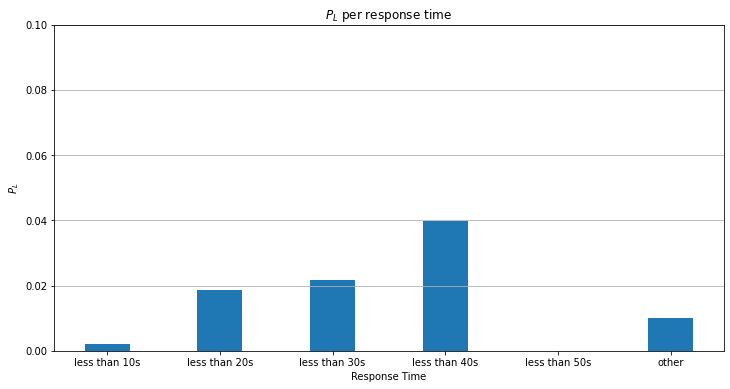

In [48]:
plt.figure(figsize = (12, 6))
plt.title(r'$P_{L}$ per response time')
params_learns = params[params['param'] == 'learns'].sort_values(by='class').copy()
labels = params_learns['class']
values = params_learns['value']
plt.bar(labels, values, width=0.4)
plt.ylabel(r'$P_{L}$')
plt.xlabel('Response Time')
plt.ylim([0, .1])
plt.grid(axis='y')
plt.show()

#### Question 4 [expected total time for BKT fitting: 8 mins]
- Use the same bins ms_first_response to categories ('less than 10s', 'less than 20s', 'less than 30s','less than 40s', 'less than 50s', 'other').
- Fit a BKT model with template-id multilearn (default), on the full data set, only for the skill 'Addition and Subtraction Integers'.
- Fit a BKT model with binned-response-time-based multilearn, on the full data set, only for the skill 'Addition and Subtraction Integers'.
- Does the binned-response-time-based multilearn improve the AUC of the model compared to the default template_id-based multilearn?

In [44]:
### EXERCISE CELL ###
skill = 'Addition and Subtraction Integers'

model = Model(seed=0, num_fits=1)
%time model.fit(data=as_data, skills=skill, multilearn=True)
default_multilearn_auc = model.evaluate(data=as_data, metric='auc')

model = Model(seed=0, num_fits=1)
%time model.fit(data=as_data, skills=skill, multilearn='bin_s_first_response')
time_multilearn_auc = model.evaluate(data=as_data, metric='auc')

'AUC Improvement using Response Time:', time_multilearn_auc - default_multilearn_auc

Wall time: 4min 2s
Wall time: 4min 35s


('AUC Improvement using Response Time:', 0.002993537586127526)

## Summary
---

In this tutorial, we have seen several important aspects of Bayesian Knowledge Tracing (BKT). We have shown how a typical data set for knowledge tracing should look like. We have illustrated how BKT models can be trained on different skills. We have shown how different variants of BKT can help you improve the goodness of your model. Many of the ideas described in this tutorial can be adapted to other data sets and projects. Finally, we have shown some examples of predictions and evaluations, covering also cross-validation. If you are interested in the implementation details of the different variants, we invite you to explore the codebase stored in the pyBKT Github repository. 